# 导入包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# 定义函数

In [2]:
def showfig(X, y):
    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.show()

# 定义类

In [3]:
class SVC():
    ''' Support Vector Machine

    Attributes:
        C {float}: 
        delta {float}:
        weight {ndarray()}: 
        bias {float}:
    '''
    def __init__(self, C=1.0, delta=0.001):
        self.C = C
        self.delta = delta
        self.weight = None
        self.bias = None
    def fit(self, X, y_true, max_iter=20, showResult=True):
        ''' Sequential Minimal Optimization
        '''
        n_samples = X.shape[0]
        alpha = np.random.uniform(size=(n_samples))     # lagrange multiplier
        bias = 0                                        # bias
        # ------------ basic functions ------------
        def chooseJ(i):
            j = i
            while j==i: 
                j = np.random.randint(0, n_samples)
            return j
        def K(i, j): 
            """ Kernel function
            """
            return np.dot(X[i], X[j])
        def f(i):
            """ f(x_i) = \sum_{m=1}^M \alpha_m y_m K_{im} + b
            """
            tmp = bias
            for m in range(n_samples):
                tmp += alpha[m] * y_true[m] * K(i, m)
            return tmp
        def E(i):
            """ E_i = f(x_i) - y_i
            """
            return f(i) - y_true[i]
        def clip(x, H, L):
            if x > H:   x = H
            elif x < L: x = L
            return x
        def weight(): 
            ''' \sum_{m=1}^M \alpha_m y_m \Phi(x_m)
            '''
            ret = 0
            for i in range(n_samples):
                ret += alpha[i]*y_true[i]*X[i].reshape((X.shape[1], 1))
            return ret
        # -------------- 迭代 --------------
        n_iter = 0                          # clear when parameter $\alpha$ updates
        while n_iter < max_iter:
            n_update = 0                    # 更新次数计数
            for i in range(n_samples):      # choose parameter i
                if ((E(i) * y_true[i] < -self.delta) and (alpha[i] < self.C)) or\
                    ((E(i) * y_true[i] > self.delta)  and (alpha[i] > 0)):  # 寻找不满足条件的乘子
                    j = -1
                    if j == -1: j = chooseJ(i)                              # 另一个不满足条件的乘子
                    # 保存旧参数
                    alpha_i_old = alpha[i]; alpha_j_old = alpha[j]
                    # 计算边界
                    if y_true[i] != y_true[j]:
                        tmp = alpha_j_old - alpha_i_old
                        L, H = max(0, tmp), min(self.C, tmp + self.C)
                    else:
                        tmp = alpha_i_old + alpha_j_old
                        L, H = max(0, tmp - self.C), min(self.C, tmp)
                    if L == H: continue
                    eta = K(i, i) + K(j, j) - 2 * K(i, j)
                    if eta < 0: continue 
                    # 更新 alpha[j]
                    alpha[j] += y_true[j] * (E(i) - E(j)) / eta
                    alpha[j] = clip(alpha[j], H, L)
                    if abs(alpha_j_old - alpha[j])<0.001: continue
                    # 更新 alpha[i]
                    alpha[i] += y_true[i] * y_true[j] * (alpha_j_old - alpha[j])
                    # 更新 bias
                    bias_i = bias - E(i) + y_true[i]*K(i, i)*(alpha_i_old - alpha[i]) + y_true[j]*K(i, j)*(alpha_j_old - alpha[j])
                    bias_j = bias - E(j) + y_true[i]*K(j, i)*(alpha_i_old - alpha[i]) + y_true[j]*K(j, j)*(alpha_j_old - alpha[j])
                    if 0 < alpha[i] and alpha[i] < self.C: bias = bias_i
                    elif 0 < alpha[j] and alpha[j] < self.C: bias = bias_j
                    else: bias = (bias_i + bias_j) / 2.0
                    # count
                    n_update += 1
                    # print("iter: %d, Args [%d, %d] updated for %d times" % (n_iter, i, j, n_update))
            if n_update == 0:
                n_iter += 1    
                # print('iter %d, no parameter updated' % (n_iter))
            else: 
                n_iter = 0      # 若alpha更新, 则清除`n_iter`计数并再次迭代
        self.weight, self.bias = weight(), bias

        if X.shape[1]==2 and showResult:
            plt.figure('result')
            x1 = X[:, 0]; x2 = X[:, 1]
            plt.scatter(x1, x2, c=y_true)
            X1 = np.linspace(min(x1), max(x1))
            X2 = -(self.weight[0]*X1 + self.bias)/self.weight[1]   
            plt.plot(X1, X2)
            plt.show()
    
    def predict(self, X):
        """ 
        Args:
            X {ndarray(n_samples, n_features)}
        Notes:
            超平面为 $ Wx + b = 0 $
        """
        a = np.sign(X.dot(self.weight) + self.bias)
        y_pred = np.sign(X.dot(self.weight) + self.bias)
        return y_pred.reshape(-1)
    def score(self, X, y_true):
        ''' accuracy
        '''
        y_pred = self.predict(X)
        return np.mean(np.equal(y_true, y_pred).astype('float'))

# 生成数据集并显示

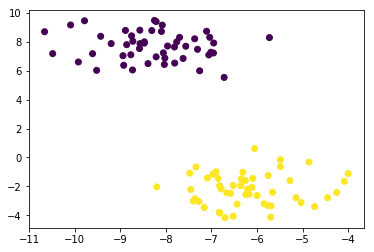

In [4]:
X, y = make_blobs(centers=2)
y[y==0] = -1	    # notes: labels \in \{0, 1\}
showfig(X, y)

# 训练并显示

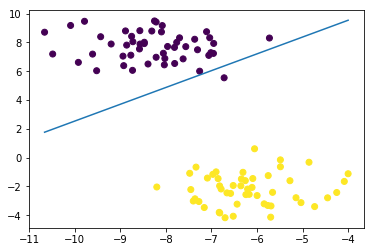

accuracy score is  99.00%


In [5]:
estimator = SVC()
estimator.fit(X, y)
y_pred = estimator.predict(X)

acc = np.mean(y==y_pred)
print("accuracy score is {: 3.2%}".format(acc))